In [23]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.nn import conv2d,max_pool2d
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.activations import relu,tanh,sigmoid
import splitfolders
import cv2
import imageio

In [2]:
# pip install split-folders

Note: you may need to restart the kernel to use updated packages.


# 1. Preprocessing of the data:

In [10]:
parent_path = "PotatoPlants"
target_class = ["Early_blight","healthy","Late_blight"]


C:\Users\gandl\AppData\Local\Temp\ipykernel_4336\1406882360.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join((parent_path + "/" + class_name),os.listdir(parent_path + "/" + class_name)[1]))


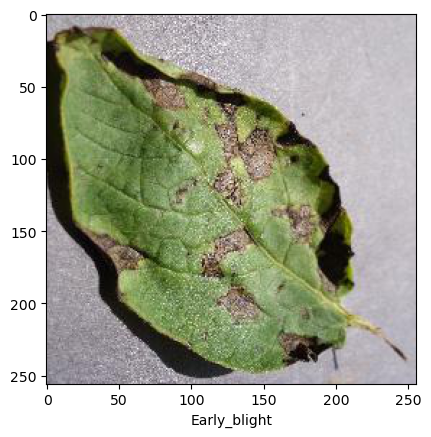

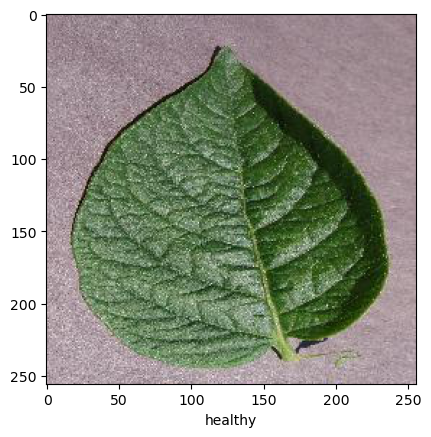

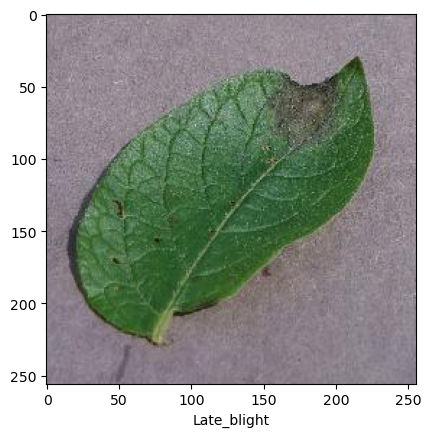

The images shape is : (256, 256, 3)


In [43]:
plt_num = 1
for class_name in target_class:
    os.listdir(parent_path + "/" + class_name)[1]
    image = imageio.imread(os.path.join((parent_path + "/" + class_name),os.listdir(parent_path + "/" + class_name)[1]))
    plt.imshow(image)
    plt.xlabel(class_name)
    plt.show()
print(f"The images shape is : {image.shape}")


The shape of the images are of the (256,256,3)i.e.,
Len = 256,
Wid = 256,
RGB = 3(Channels)


In [45]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory = parent_path, batch_size = 32,image_size = (256,256),shuffle = True)

Found 2152 files belonging to 3 classes.


In [46]:
dataset.class_names

['Early_blight', 'Late_blight', 'healthy']

In [48]:
len(dataset)

68

# Function to get the Train,Test,Split Dataset 

In [49]:
def split_data(dataset,train_size = 0.7,test_size = 0.1,val_size = 0.2):
    dataset_size = len(dataset)
    train_data = dataset.take(int(dataset_size*train_size))
    val_data = dataset.skip(int(dataset_size*train_size)).take(int(dataset_size * val_size))
    test_data = dataset.skip(int(dataset_size*train_size)+int(dataset_size * val_size)).take(int(dataset_size*test_size))
    return train_data,val_data,test_data

In [50]:
train_data,val_data,test_data = split_data(dataset)

In [69]:
for image_batch , lables_batch in dataset.take(1):
    print(image_batch.numpy().shape)

(32, 256, 256, 3)


# Preprocessing

### Resize Rescale

In [71]:
resize_rescale = Sequential([
    keras.layers.Resizing(256,256),
    keras.layers.Rescaling(1.0/255),
])

# Model Creation:

In [75]:
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten

In [83]:
model = Sequential([
    resize_rescale,
    
    #layer 1
    Conv2D(filters = 32,kernel_size = (3,3),strides = 2, padding = "valid",activation = relu,input_shape=(32,256,256,3)),
    MaxPool2D((2,2)),
    
    #layer-2
    Conv2D(filters = 64, kernel_size = (3,3),strides = 2, padding = "valid" , activation = relu),
    MaxPool2D((2,2)),
    
    #layer-3:
    Conv2D(filters = 32,kernel_size = (3,3), strides = 1, padding =  "valid" , activation = relu),
    MaxPool2D((2,2)),
    
    Flatten(),
    
    #Neural Network:
    Dense(64,activation = relu),
    Dense(3,activation = sigmoid),
    
    
    
    
])

In [85]:
model.build(input_shape = (32,256,256,3))

In [92]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False) ,optimizer = "adam", metrics=  ["accuracy"])

In [88]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (32, 127, 127, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 63, 63, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (32, 31, 31, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (32, 15, 15, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (32, 13, 13, 32)         

In [107]:
history = model.fit(train_data,epochs = 50,validation_data = val_data)

Epoch 1/50
47/47 [==============================] - 4s 92ms/step - loss: 4.0212e-04 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9952
Epoch 2/50
45/47 [===========================>..] - ETA: 0s - loss: 3.3399e-04 - accuracy: 1.0000

KeyboardInterrupt: 

In [95]:
model.evaluate(test_data) #loss value , accuruacy

6/6 [==============================] - 1s 27ms/step - loss: 0.0047 - accuracy: 1.0000


[0.004729398991912603, 1.0]

In [96]:
model.save("model.h5")

C:\Users\gandl\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [103]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


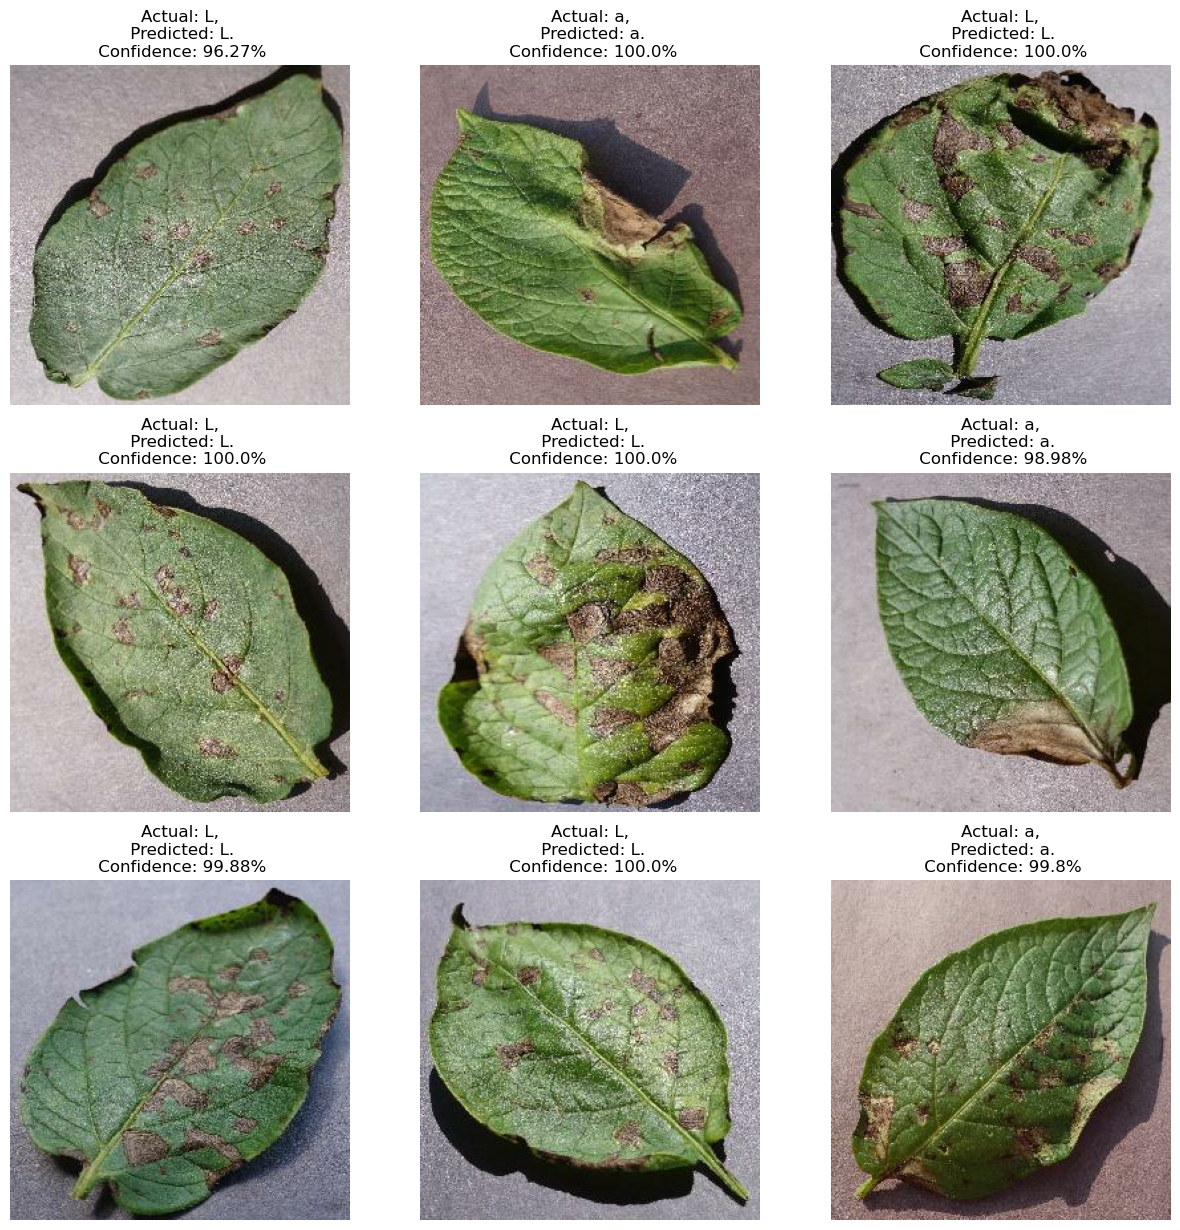

In [106]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")